In [1]:
import numpy as np
import pandas as pd
import seaborn as sns; sns.set()
import scipy
import os

In [2]:
# project files

from utils.variables import pack, unpack
from utils.display import table, tabulate
from utils.files import download_sheet, save, load
from utils.hash import digest

from fit_options import fit_options
from game_model import game
from rp_model import compute_rp, make_precomputed_columns
from initial_guess import make_initial_guess


In [3]:
# stuff for display

from IPython.lib.pretty import pretty, pprint

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 120)

In [4]:
refresh_rp_file = True

rp_file_id = "1kBrPl0pdAO8gjOf_NrTgAPseFtqQA27fdfEbMBBeAhs"

sheet_ids = {
    "data_1_9":   "1682088244",
    "data_10_49": "1691041080",
}

if (refresh_rp_file):

    data_1_9 = download_sheet(rp_file_id, sheet_ids["data_1_9"])
    data_10_49 = download_sheet(rp_file_id, sheet_ids["data_10_49"])
    
    data = pd.concat([data_1_9, data_10_49], axis = 0)
    data = data.dropna(subset=["Pokemon","Level","RP","Nature","MS lvl"])
    data = data.fillna({'Amnt':0 ,'Ing2P':0, 'Help skill bonus': 1, 'RP Multiplier': 1, 'ModelRP': -1, 'Difference': -1})
    data = data.fillna({'Sub Skill 1':'','Sub Skill 2':'', 'Ingredient 2': '', 'Source':''})

    # data above 30 requires a 2nd ingredient to be valid.
    data = data[ ~( (data["Level"] >= 30) & (data["Amnt"] == 0.0)  ) ]

    # data below 30 we clear 2nd ingredient
    data["Amnt"].loc[data["Level"] < 30] = 0.0
    data["Ing2P"].loc[data["Level"] < 30] = 0.0
    data["Ingredient 2"].loc[data["Level"] < 30]= ""

    # data below 25 we clear 2nd skill, and below 10 we clear the 1st
    data["Sub Skill 2"].loc[data["Level"] < 25] = ""
    data["Sub Skill 1"].loc[data["Level"] < 10] = ""

    # avoid a bug in RP of freshly caught mon with skill up unlocked.
    # (We now trust the bugged data is quarantined so we can use the valid data)
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up S") & (data["MS lvl"] == 2) )]
    # data = data[ ~( (data["Sub Skill 1"] == "Skill Level Up M") & (data["MS lvl"] == 3) )]

    # only use data known to the Pokedex (we'll update Pokedex as needed)
    data = data[ data["Pokemon"].isin( game.pokedex.data["Pokemon"] ) ]
    
    data.to_pickle(fit_options.data_file)
    
else:
    
    data = pd.read_pickle(fit_options.data_file)


C:\Users\jckin\AppData\Local\Temp\ipykernel_27200\2334480957.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Amnt"].loc[data["Level"] < 30] = 0.0
C:\Users\jckin\AppData\Local\Temp\ipykernel_27200\2334480957.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Ing2P"].loc[data["Level"] < 30] = 0.0
C:\Users\jckin\AppData\Local\Temp\ipykernel_27200\2334480957.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["Ingr

In [5]:
data.describe()
data.head()

,Level,RP,MS lvl,ModelRP,Difference,Freq1,FreqL,Inv,Berry1,BerryL,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,BerryD,IngD,Dupes,Amnt,Ing2P,Help skill bonus,RP Multiplier
count,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.000000,6251.00000,6251.000000,6251.000000,6251.000000,6251.000000,6185.000000,6251.000000,6251.000000,6251.000000,6251.0,6251.000000,6251.000000,6251.000000,6251.000000
mean,10.539754,604.216765,1.490162,598.748071,0.018907,3957.958727,3808.092725,12.225724,28.039674,37.679251,108.799072,1.01804,0.988365,0.994420,1.001760,1.005919,0.207669,32.246559,55.161894,148.545993,1.0,0.073268,2.998080,0.987581,1.027236
std,7.143925,389.951541,0.983231,395.586862,0.987593,962.682216,1024.731656,3.384683,2.612284,8.012329,15.999728,0.30429,0.059484,0.044932,0.117807,0.117834,0.046656,36.406872,27.743413,60.567634,0.0,0.514501,20.567088,0.037777,0.069380
min,1.000000,245.000000,1.000000,-1.000000,-12.780000,2200.000000,1489.118400,7.000000,24.000000,24.000000,90.000000,0.52000,0.890000,0.920000,0.800000,0.800000,0.000000,0.000000,25.000000,90.000000,1.0,0.000000,0.000000,0.790000,1.000000
25%,5.000000,354.000000,1.000000,352.475000,-0.290000,3300.000000,2954.070000,10.000000,26.000000,32.000000,98.000000,0.80000,1.000000,1.000000,1.000000,1.000000,0.180000,12.820000,35.000000,101.000000,1.0,0.000000,0.000000,1.000000,1.000000
50%,10.000000,460.000000,1.000000,458.090000,-0.020000,3900.000000,3796.100000,12.000000,28.000000,36.000000,103.000000,0.94000,1.000000,1.000000,1.000000,1.000000,0.200000,19.750000,45.000000,121.000000,1.0,0.000000,0.000000,1.000000,1.000000
75%,14.000000,711.000000,2.000000,711.185000,0.270000,4500.000000,4455.000000,14.000000,31.000000,41.000000,115.000000,1.21000,1.000000,1.000000,1.000000,1.000000,0.240000,43.980000,68.000000,202.000000,1.0,0.000000,0.000000,1.000000,1.000000
max,42.000000,3440.000000,6.000000,3440.330000,15.410000,6300.000000,6916.140000,23.000000,35.000000,77.000000,151.000000,2.41000,1.120000,1.080000,1.200000,1.200000,0.420000,414.030000,222.000000,511.000000,1.0,8.000000,342.000000,1.000000,1.440000


,Pokemon,Level,RP,Nature,MS lvl,Source,ModelRP,Difference,Nature2,ID,NatureP,NatureN,Freq1,FreqL,Type,Class,MSkill,Inv,Berry1,BerryL,Ing1,Ing1P,Helps per hour,Helps Neutral,NrgMult,IngrMult,SkillMult,Ingr%,SklContr,RPneutral,IDNeutral,BerryD,IngD,Dupes,DupeMatch,Sub Skill 1,Sub Skill 2,Ingredient 2,Amnt,Ing2P,Help skill bonus,RP Multiplier
0,Arbok,9.0,574.0,Naughty,1.0,Rate My Mon,574.41,0.41,Naughty,ArbokNaughty91,Speed of Help,Main Skill Chance,3700.0,3276.72,Poison,Berries,Charge Energy S,14.0,32.0,40,Bean Sausage,103.0,1.09,0.90,1.00,1.0,0.8,0.26,22.76,538.37,ArbokNeutral91,80.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
1,Arbok,8.0,531.0,Hardy,1.0,Questions help guides,530.69,-0.31,Neutral,ArbokNeutral81,-,-,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.0,1.0,0.26,22.76,531.00,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
2,Arbok,8.0,538.0,Quiet,1.0,Questions help guides,538.08,0.08,Quiet,ArbokQuiet81,Ingredient Finding,Exp Gains,3700.0,3648.20,Poison,Berries,Charge Energy S,14.0,32.0,39,Bean Sausage,103.0,0.98,1.00,1.00,1.2,1.0,0.26,22.76,530.61,ArbokNeutral81,78.0,103.0,1,True,,,,0.0,0.0,1.0,1.0
3,Arcanine,5.0,958.0,Calm,3.0,,957.85,-0.15,Calm,ArcanineCalm53,Main Skill Chance,Speed of Help,2500.0,2728.00,Fire,Skills,Extra Helpful S,16.0,27.0,31,Fiery Herb,130.0,1.31,1.11,1.00,1.0,1.2,0.14,84.52,937.81,ArcanineNeutral53,31.0,130.0,1,True,,,,0.0,0.0,1.0,1.0
4,Arcanine,3.0,715.0,Lax,2.0,pokemon sleep general,714.65,-0.35,Lax,ArcanineLax32,Energy Recovery,Main Skill Chance,2500.0,2490.00,Fire,Skills,Extra Helpful S,16.0,27.0,29,Fiery Herb,130.0,1.44,1.00,1.08,1.0,0.8,0.14,61.23,750.25,ArcanineNeutral32,29.0,130.0,1,True,,,,0.0,0.0,1.0,1.0


In [6]:
# Make an initial guess
# Pack the dictionary into a 1-D vector.
# Also store information on how to unpack that vector

x0, unpack_info = pack(make_initial_guess())


In [7]:
# Compute per sample information about help time, nature, sub-skills etc
computed = make_precomputed_columns(data)

# Do we match the sheet? Yes
(computed.helps_per_hour - data["Helps per hour"]).describe()

count    6251.0
mean        0.0
std         0.0
min         0.0
25%         0.0
50%         0.0
75%         0.0
max         0.0
Name: Helps per hour, dtype: float64

In [8]:
# We compute the RP model in rp_model.py
# Here we create closure to glue the pieces together.

def RP(x):
    return compute_rp(x, data, computed, unpack_info)

def residual(x):
    return data["RP"].to_numpy() - RP(x)


count    6251.000000
mean        0.474877
std         0.904760
min         0.000053
25%         0.135469
50%         0.281871
75%         0.441666
max        12.924384
dtype: float64

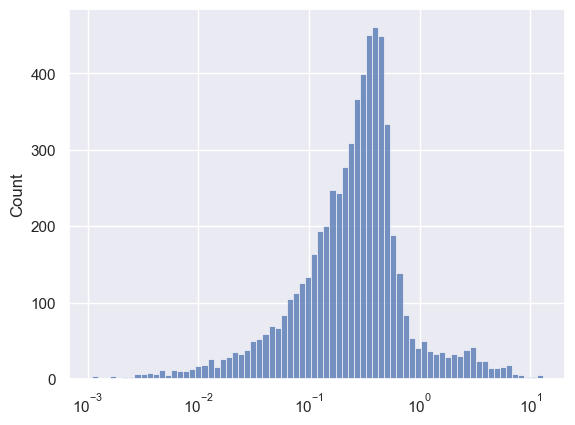

In [9]:
# what is the quality of the initial guess?

r = np.abs(residual(x0))
pd.Series(r).describe()
_ = sns.histplot(x=r[r>1e-3], log_scale=True)

In [10]:
cache_fit = True

# least_squares gives a deterministic result that depends on x0, the data, and the optimizer options
# hash the data as well as x0 to decide if we reuse last fit

filename = fit_options.result_file(digest(data, x0))

if cache_fit and os.path.isfile(filename):
    opt = load(filename)
    print("Loaded from cache")
else:
    opt = scipy.optimize.least_squares(residual, x0, **fit_options.least_squares_kwargs)
    
    # save results and remove some stuff we don't need to save.
    del opt.jac
    del opt.active_mask
    del opt.fun
    
    save(filename, opt)

   Iteration     Total nfev        Cost      Cost reduction    Step norm     Optimality   
       0              1         1.2977e+03                                    1.12e+07    
       1              6         1.2768e+03      2.10e+01       7.14e-03       7.93e+06    
       2              7         1.2258e+03      5.09e+01       1.78e-03       2.31e+06    
       3              8         1.1601e+03      6.57e+01       4.46e-04       2.93e+05    
       4             10         1.1411e+03      1.90e+01       2.23e-04       6.88e+05    
       5             11         1.1350e+03      6.16e+00       4.46e-04       2.19e+04    
       6             12         1.1277e+03      7.24e+00       8.92e-04       4.62e+03    
       7             13         1.1219e+03      5.86e+00       1.78e-03       1.38e+04    
       8             14         1.1206e+03      1.27e+00       3.57e-03       5.83e+04    
       9             15         1.1203e+03      2.75e-01       7.14e-03       1.37e+03    

In [11]:
opt

    message: `ftol` termination condition is satisfied.
    success: True
     status: 2
          x: [ 2.563e-01  2.545e-01 ...  2.195e-01  9.953e-01]
       cost: 1119.3668854526234
       grad: [ 2.956e-05 -3.122e-05 ...  8.217e-05 -7.706e-05]
 optimality: 2.1351560882176273
       nfev: 21
       njev: 16

count    6251.000000
mean        0.436726
std         0.833031
min         0.000098
25%         0.133061
50%         0.272064
75%         0.427538
max        12.858797
dtype: float64

<Axes: ylabel='Count'>

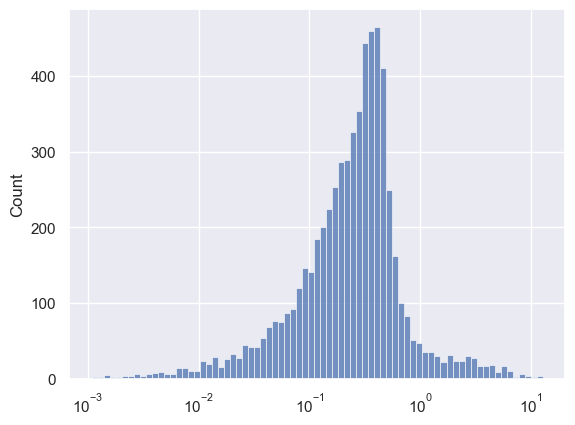

In [12]:
r_opt = np.abs(residual(opt.x))
pd.Series(r_opt).describe()
sns.histplot(x=r_opt[r_opt>1e-3], log_scale=True)

In [13]:
sol = unpack(opt.x, unpack_info)

table(sol)

Pokemons ing fractions,[0.25630155 0.25445903 0.26576887 ... 0.17956784 0.20047827 0.21660219]
Pokemons skill products,[16.71210849 16.70304112 18.42398833 ... 44.70504018 12.79907181 15.2761437 ]
Charge Strength S,[0.74710752 0.32235687]
Charge Strength M,[0.7449807 0.3227861]
Ingredient Magnet S,[0.74555037 0.32266452]
Cooking Power-Up S,[0.74521938 0.3226573 ]
Extra Helpful S,[0.74576013 0.32241635]
Charge Energy S,[0.74791243 0.32225601]
Energizing Cheer S,[0.7450721 0.3233056]
Energy for Everyone S,[0.74548057 0.32277128]
Dream Shard Magnet S,[0.74551339 0.32260973]


In [14]:
# Format ing% and skillProduct pretty

res = pd.DataFrame({"Pokemon":game.pokedex.data["Pokemon"], "ing%": sol["Pokemons ing fractions"]*100.0, "skill% * skillValue": sol["Pokemons skill products"] })
res.set_index("Pokemon")

,ing%,skill% * skillValue
Pokemon,,
Bulbasaur,25.630155,16.712108
Ivysaur,25.445903,16.703041
Venusaur,26.576887,18.423988
Charmander,20.039861,9.677441
Charmeleon,22.651751,14.058965
Charizard,22.392651,14.026430
Squirtle,27.004731,17.615755
Wartortle,27.042762,17.580446
Blastoise,27.432003,18.440532


In [15]:
# Format main skill growth per level 

growth_display = {}
levels = np.array(list(range(2,7)))
growth_display["Level"] = levels

for record in game.mainskills.data.to_dict(orient='records') :   
    
    skillname = record["Skill"]
    params = sol[skillname]
    growth_display[skillname] = params[0]*np.exp(params[1]*levels)
    
df = pd.DataFrame(growth_display)
df.set_index("Level")


,Charge Strength S,Charge Strength M,Ingredient Magnet S,Cooking Power-Up S,Extra Helpful S,Charge Energy S,Energizing Cheer S,Energy for Everyone S,Dream Shard Magnet S,Metronome
Level,,,,,,,,,,
2,1.423570,1.420736,1.421477,1.420825,1.421171,1.424816,1.422388,1.421647,1.421251,1.421833
3,1.965063,1.961994,1.962778,1.961864,1.961869,1.966585,1.965295,1.963223,1.962358,1.964112
4,2.712529,2.709455,2.710208,2.708927,2.708281,2.714356,2.715424,2.711112,2.709480,2.713213
5,3.744313,3.741676,3.742261,3.740465,3.738672,3.746457,3.751867,3.743909,3.741051,3.748017
6,5.168565,5.167142,5.167322,5.164804,5.161085,5.171003,5.183908,5.170149,5.165367,5.177489


In [16]:
# What are the worst points?

df = data[["Pokemon","ID","Level","MS lvl","NatureP","NatureN","Sub Skill 1","Sub Skill 2","RP"]].copy()

df["fit"] = RP(opt.x)
df["error"] = residual(opt.x)
df["error2"] = df["error"]**2

df = df.sort_values("error2", ascending = False)
df.head(100)

,Pokemon,ID,Level,MS lvl,NatureP,NatureN,Sub Skill 1,Sub Skill 2,RP,fit,error,error2
2801,Victreebel,VictreebelNeutral313Energy Recovery BonusInven...,31.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1713.0,1700.141203,12.858797,165.348661
1234,Gengar,GengarMild303Inventory Up MSleep EXP Bonus,30.0,3.0,Ingredient Finding,Energy Recovery,Inventory Up M,Sleep EXP Bonus,1904.0,1891.200237,12.799763,163.833922
2802,Victreebel,VictreebelNeutral323Energy Recovery BonusInven...,32.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1751.0,1738.335496,12.664504,160.389650
2803,Victreebel,VictreebelNeutral333Energy Recovery BonusInven...,33.0,3.0,-,-,Energy Recovery Bonus,Inventory Up M,1769.0,1757.224383,11.775617,138.665151
2159,Raichu,RaichuLonely302Inventory Up MHelping bonus,30.0,2.0,Speed of Help,Energy Recovery,Inventory Up M,Helping bonus,1754.0,1743.154336,10.845664,117.628418
2817,Walrein,WalreinImpish333Berry Finding SHelping bonus,33.0,3.0,Energy Recovery,Ingredient Finding,Berry Finding S,Helping bonus,2205.0,2215.030370,-10.030370,100.608313
2603,Togekiss,TogekissGentle103Skill Trigger M,10.0,3.0,Main Skill Chance,Energy Recovery,Skill Trigger M,,1282.0,1272.644307,9.355693,87.528992
2205,Raticate,RaticateBrave301Inventory Up MSleep EXP Bonus,30.0,1.0,Speed of Help,EXP Gains,Inventory Up M,Sleep EXP Bonus,1250.0,1240.686125,9.313875,86.748266
398,Charizard,CharizardMild276Helping Speed MSkill Level Up M,27.0,6.0,Ingredient Finding,Energy Recovery,Helping Speed M,Skill Level Up M,1514.0,1504.706893,9.293107,86.361842
427,Charizard,CharizardRash273Helping bonusHelping Speed M,27.0,3.0,Ingredient Finding,Main Skill Chance,Helping bonus,Helping Speed M,1440.0,1431.064403,8.935597,79.844894
